In [1]:
import numpy as np
import matplotlib.pyplot as plt

UNITS = 1024
KER_DENSITY = 0.15
DT = 0.1
MEMBRANE_TIME_SCALE_TAU_M = 5.0
MEMBRANE_RESISTANCE_R = 500.0
V_REST = -70.0
V_RESET = -51.0
RHEOBASE_THRESHOLD_V_RH = -50.0
SHARPNESS_DELTA_T = 2.0
ADAPTATION_VOLTAGE_COUPLING_A = 0.5
ADAPTATION_TIME_CONSTANT_TAU_W = 10.0
SPIKE_TRIGGERED_ADAPTATION_INCREMENT_B = 5.0
FIRING_THRESHOLD_V_SPIKE = -30.0
SYNAPSE_STRENGTH = 30.0 / UNITS

SIM_SECONDS = 100
SIM_REPS = 100

In [ ]:
from _brian2 import brian_adex_performance_non_interactive
import brian2 as b2

k_times = [
    0.1, # [0.1ms]
    1.0, # [1ms]
    2.0, # [2ms]
    5.0, # [5ms]
    10.0, # [10ms]
    50.0, # [50ms]
]
t_max = SIM_SECONDS * b2.second

b2_times_non_inter = []
print(f'Brian2 (non-interactive): Running {SIM_SECONDS}s simulations, 10 times each')
for k in k_times:
    times = brian_adex_performance_non_interactive(
        t_max = t_max,
        k_time = k * b2.ms,
        units = 1024,
        ker_density = 0.15,
        synapse_strength = SYNAPSE_STRENGTH,
        dt = DT * b2.ms,
        tau_m = MEMBRANE_TIME_SCALE_TAU_M * b2.ms,
        R = MEMBRANE_RESISTANCE_R * b2.Mohm,
        v_rest = V_REST * b2.mV,
        v_reset = V_RESET * b2.mV,
        v_rheobase = RHEOBASE_THRESHOLD_V_RH * b2.mV,
        a = ADAPTATION_VOLTAGE_COUPLING_A * b2.nS,
        b = SPIKE_TRIGGERED_ADAPTATION_INCREMENT_B * b2.pA,
        firing_threshold = FIRING_THRESHOLD_V_SPIKE * b2.mV,
        delta_T = SHARPNESS_DELTA_T * b2.mV,
        tau_w = ADAPTATION_TIME_CONSTANT_TAU_W * b2.ms,
    )
    b2_times_non_inter.append(times)
    print(f'{k} ms steps:\t{np.mean(times):.4f} ± {np.std(times, ddof=1):.4f}')
np.save(f'./b2_times_non_inter_t{SIM_SECONDS}r{SIM_REPS}.npy', b2_times_non_inter)

Brian2 (non-interactive): Running 100s simulations, 10 times each
0.1 ms steps:	247.3573 ± 1.5272
1.0 ms steps:	253.3219 ± 0.8312
2.0 ms steps:	253.6008 ± 1.5311
5.0 ms steps:	253.2990 ± 1.3116
10.0 ms steps:	253.0081 ± 1.0943
50.0 ms steps:	252.7526 ± 1.5764


In [ ]:
from _spark import spark_adex_performance

k_steps = [
	1, # [0.1ms]
	10, # [1ms]
	20, # [2ms]
	50, # [5ms]
	100, # [10ms]
	500, # [50ms]
]
t_max = int((SIM_SECONDS * 1000) / DT)

spark_times = []
print(f'Spark: Running {SIM_SECONDS}s simulations, 10 times each')
for k in k_steps:
	# Get clean state
	times = spark_adex_performance(
		t_steps = t_max, 
		k_steps = k,
		units = UNITS,
		ker_density = KER_DENSITY,
		dt = DT,
		synapse_strength = SYNAPSE_STRENGTH,
		potential_rest = V_REST,
		potential_reset = V_RESET,
		potential_tau = MEMBRANE_TIME_SCALE_TAU_M,
		resistance = MEMBRANE_RESISTANCE_R,
		threshold = FIRING_THRESHOLD_V_SPIKE,
		rheobase_threshold = RHEOBASE_THRESHOLD_V_RH,
		spike_slope = SHARPNESS_DELTA_T,
		adaptation_tau = ADAPTATION_TIME_CONSTANT_TAU_W,
		adaptation_delta = SPIKE_TRIGGERED_ADAPTATION_INCREMENT_B / 1000, # pA -> nA
		adaptation_subthreshold = ADAPTATION_VOLTAGE_COUPLING_A / 1000,	# nS -> µS
	)
	spark_times.append(times)
	print(f'{k} steps:\t{np.mean(times):.4f} ± {np.std(times, ddof=1):.4f}')
np.save(f'./spark_times_t{SIM_SECONDS}r{SIM_REPS}.npy', spark_times)

Spark: Running 100s simulations, 10 times each
1 steps:	444.1801 ± 0.7569
10 steps:	47.2569 ± 0.0572
20 steps:	24.9896 ± 0.0930
50 steps:	11.7186 ± 0.0366
100 steps:	8.7126 ± 0.0108
500 steps:	8.0420 ± 0.0027


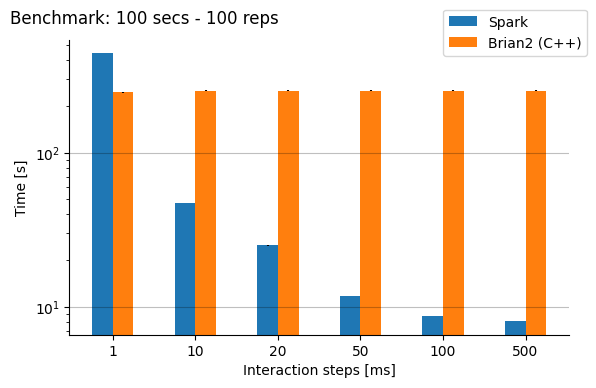

In [3]:
w = 0.25
o = w/2
k_steps = [
	1, # [0.1ms]
	10, # [1ms]
	20, # [2ms]
	50, # [5ms]
	100, # [10ms]
	500, # [50ms]
]

spark_times = np.load(f'./spark_times_t{SIM_SECONDS}r{SIM_REPS}.npy')
b2_times_non_inter = np.load(f'./b2_times_non_inter_t{SIM_SECONDS}r{SIM_REPS}.npy')

fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.bar(np.arange(len(spark_times))-o, np.mean(spark_times, axis=1), yerr=np.std(spark_times, axis=1, ddof=1), width=w, label='Spark')
ax.bar(np.arange(len(b2_times_non_inter))+o, np.mean(b2_times_non_inter, axis=1), yerr=np.std(b2_times_non_inter, axis=1, ddof=1), width=w, label='Brian2 (C++)')

ax.legend(bbox_to_anchor=(1.05, 1.125))
ax.set_xticks(np.arange(len(spark_times)), k_steps)
ax.set_xlabel('Interaction steps [ms]')
ax.set_ylabel('Time [s]')
ax.set_yscale('log')
ax.set_title(f'Benchmark: {SIM_SECONDS} secs - {SIM_REPS} reps', x=0.15, y=1.025)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', color='k', alpha=0.25)
fig.tight_layout()